In [191]:
import os, sys, collections, re, json, io, base64
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy
import warnings
import urllib
import urllib.request
import bs4 as bs
import IPython
import sklearn
import xlrd
import statsmodels.formula.api as smapi
import statsmodels.tsa.stattools as ts
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option("display.max.rows", 3000)
pd.set_option("display.max.columns", 3000)

from datetime import datetime
from pandas import Series
from IPython.display import display, Math, Latex
from IPython.external import mathjax
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from IPython.display import display, HTML
from urllib.request import urlopen
from bs4 import BeautifulSoup  # BeautifulSoup 4

<H2 align="center"> Rethinking Rig Count as a Predictor of Production<br> <br>  Evidence from the United States <br> <br>   <h4> <center> Work In Progress </center></h4></center></H2> <br> <br><br> 


### Abstract
This jupyter notebook examines the relationship between the number of drilling rigs actively developing oil and the crude oil production level in the United States. I empirically verify the impact the rig count has on production. I find that the relationship between the rig count and the production level is linear when operators are expanding and growing their rig count: New rigs are needed to be put to work in order for production to grow. On the contrary, the relationship is not as prominent when rigs are falling; as operators can focus their drilling activity in the sweet spots, resulting in increased rig productivity.

### Introduction
In the past, the number of oil-oriented drilling rigs was conclusively indicative of oil production growth. However, technological advances have resulted in operators finding ways of increasing production without adding more rigs. This jupyter notebook examines if the rig count is still relevant: if you can’t trust the rig count report, what should you trust? 
### Theory
Oil drilling rigs are used to identify geologic reservoirs and to create wells that allow the extraction of oil from those reservoirs. A drilling rig is a necessary evil for production to take place, making the U.S. rotary rig count a fundamental determinant of current and future production capabilities. In order to put a drilling rig to work, money, or capital expenditures, are needed. Capital expenditures represents all the costs involved in drilling and completing wells, purchasing equipment, land drilling rights, and other long-lived assets required to run the business. Intuitively, operators 
E&P budget will be a direct function of the oil price, resulting in the following relationship.  

Spot Price &#11177; Capital Expenditures &#11177; Rotary Rig Count &#11177; Well Completion &#11177; Crude Production

### Data

The Baker Hughes North American Rotary Rig Count is a weekly census of the number of drilling rigs actively exploring for or developing oil in the United States. A rotary rig rotates the drill pipe from surface to drill a new well (or sidetracking an existing one) to explore for, develop and produce oil. The Baker Hughes Rotary Rig count includes only those rigs that are significant consumers of oilfield services and supplies and does not include cable tool rigs, very small truck mounted rigs or rigs that can operate without a permit. Non-rotary rigs may be included in the count based on how they are employed. For example, coiled tubing and workover rigs employed in drilling new wells are included in the count. To be counted as active a rig must be on location and be drilling or 'turning to the right'. A rig is considered active from the moment the well is "spudded" until it reaches target depth. Rigs that are in transit from one location to another, rigging up or being used in non-drilling activities such as workovers, completions or production testing, are not counted as active. Since 1940 the highest weekly US rig count was 4,530 recorded on December 28, 1981. The lowest U.S. rig count was recorded in 2016. For data covering the U.S. crude oil production level, I use the EIA Weekly Petroleum Status report. The weekly production data is published on Wednesday while the rotary rig count data is published on Friday, which may cause a mismatch problem.

In [192]:
import requests # Original data source is xlsb
dls = "http://phx.corporate-ir.net/External.File?item=UGFyZW50SUQ9NzA0ODM3fENoaWxkSUQ9NDE3MTQzfFR5cGU9MQ==&t=1"
resp = requests.get(dls)

output = open('Rig.xlsb', 'wb')
output.write(resp.content)
output.close()

In [193]:
import csv # Convert xlsb to csv
from pyxlsb import open_workbook

with open_workbook('Rig.xlsb') as wb:
    for name in wb.sheets:
        with wb.get_sheet(name) as sheet, open(name + '.csv', 'w') as f:
            writer = csv.writer(f)
            for row in sheet.rows():
                writer.writerow([c.v for c in row])

In [194]:
df = pd.read_csv(r"C:\Users\mla\Dev\cfehome\US Count by Basin.csv", skiprows=19, index_col="Date", parse_dates=["Date"])

df = df.dropna(axis=1, how='all')
df.dropna(inplace=True)

# Convert values into a new column named "converted"
df["date"] = df.index.map(lambda x: datetime(*xlrd.xldate_as_tuple(x, 0)))

df.reset_index(inplace=True)
df.set_index('date', inplace=True)

df_cols = ['code','Ardmore_Oil','Ardmore_Gas','Ardmore_Misc','Ardmore_Total', 'Arkoma_Oil','Arkoma_Gas','Arkoma_Misc','Arkoma_Total', 'Barnett_Oil','Barnett_Gas','Barnett_Misc','Barnett_Total', 'Cana_Oil','Cana_Gas','Cana_Misc','Cana_Total', 'Niobrara_Oil','Niobrara_Gas','Niobrara_Misc','Niobrara_Total','EagleFord_Oil','EagleFord_Gas','EagleFord_Misc','EagleFord_Total','Fayetteville_Oil','Fayetteville_Gas','Fayetteville_Misc','Fayetteville_Total', 'Granite_Oil','Granite_Gas','Granite_Misc','Granite_Total', 'Haynesville_Oil','Haynesville_Gas','Haynesville_Misc','Haynesville_Total', 'Marcellus_Oil','Marcellus_Gas','Marcellus_Misc','Marcellus_Total', 'Mississippian_Oil','Mississippian_Gas','Mississippian_Misc','Mississippian_Total', 'Permian_Oil','Permian_Gas','Permian_Misc','Permian_Total', 'Utica_Oil','Utica_Gas','Utica_Misc','Utica_Total', 'Williston_Oil','Williston_Gas','Williston_Misc','Williston_Total', 'Others_Oil','Others_Gas','Others_Misc','Others_Total', 'RigCount','Total_Gas','Total_Misc','Total' ]
df.columns = df_cols

In [195]:
# U.S. weekly production data
dfData = pd.read_excel('http://ir.eia.gov/wpsr/psw01.xls', "Data 2", index_col="Date", parse_dates=["Date"], skiprows=2)

# Rename cols
dfData_cols = ['US_production_crude','Alaska_production_crude','lower48_production_crude','crude_netImports','crude_Imports','imports_excSpr','importsby_spr', 'importsfor_spr','crude_exports','stock_change','SPR_change','change_excSPR', 'crude_unaccounted','refinery_input','refinery_production_netGas','gasLiquids_production','renewable_production','Oxygenate','Fuel-Oxygenates',' Processing_Gain', 'netImports_products','products_imports', 'products_exports', 'products_change', 'supply_adjustment_products', 'products_supplied', 'Motor_Gasoline','Jet_Fue','Distillate_Fuel ' ,' Residual_Fuel' ,' Propane_Propylene' ,'Other_Oils ' ,'netImports_petroleum_products']
dfData.columns = dfData_cols

# Subset
dfData= dfData["2011-01-25":"2050"] # Matching problem, production data series published on Wensday & rig count on Friday

#dfData.index = df.index 

df = pd.concat([dfData, df], axis= 1)

# Mismatch between dataseries
# Rig count published Friday, Production published Wednesday
df = df.fillna(method='ffill')

### Empirical results

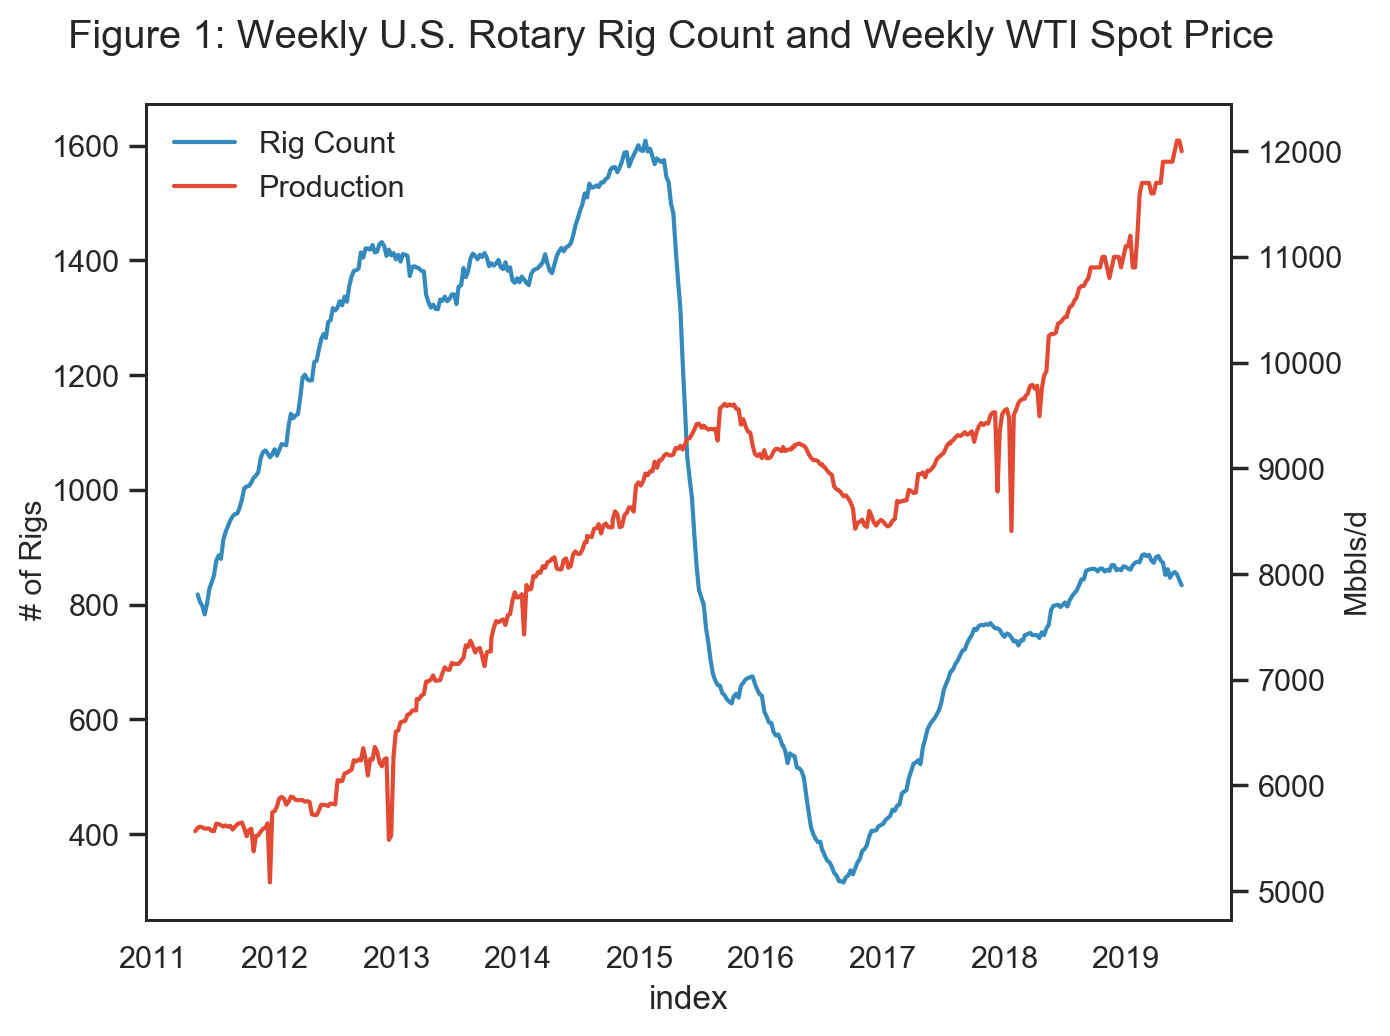

In [216]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df['US_production_crude'].plot(secondary_y=True, label='Production')
ax1 = df['RigCount'].plot(label='Rig Count')
ax2 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.suptitle('Figure 1: Weekly U.S. Rotary Rig Count and Weekly WTI Spot Price', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.035, 0.5, '# of Rigs', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Mbbls/d', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

Figure 1 displays crude oil production and the rotary rig count over time for the United States. A casual review of the data suggests a predictable relationship between the number of drilling rigs and the production output; however, the magnitude and extent of this relationship is unclear. Domestic production generally lags the rig count and leads oil and gas employment. 

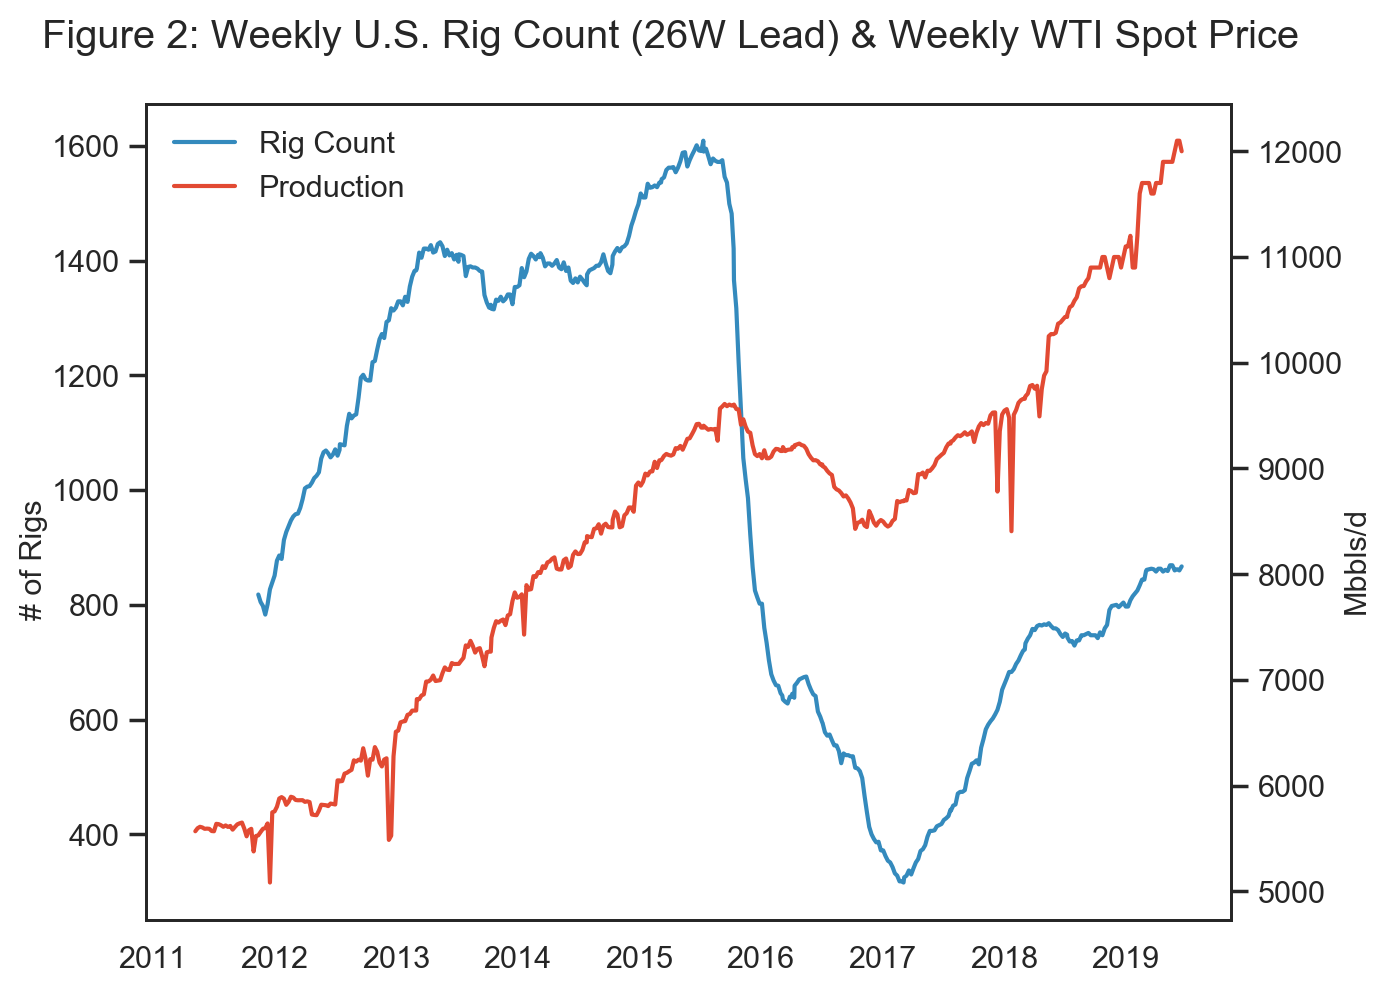

In [198]:
df['RigCountShift']= df['RigCount'].shift(26)
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df['US_production_crude'].plot(secondary_y=True, label='Production')
ax1 = df['RigCountShift'].plot(label='Rig Count')
ax2 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.suptitle('Figure 2: Weekly U.S. Rig Count (26W Lead) & Weekly WTI Spot Price', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.035, 0.5, '# of Rigs', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Mbbls/d', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

Figure 2 is identical to figure 1, except that the U.S. rotary rig count is now shifted 26 weeks forward. There are several 
reasons that explain the presence and relevance of leads in drilling rigs. Companies bring new rigs online a few months before they expect to need the output in order to give themselves time to get them into full production. 
To bring a rig online is a process, and even when a rig is in production mode it isn’t necessarily running at full capacity.
Hence, analysts and investors should expect an estimated lag time from drilling activity to new-well production. The rig count is shifted 26 weeks. In some cases, where either data or industry reports suggest otherwise, a different lag may be used.

In [199]:
#Spot Prices for Crude Oil
dfSpot = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_W.xls', "Data 1", parse_dates=["Date"], index_col="Date", skiprows=[0,1])

# Rename cols
dfSpot_cols = ['WTI', 'Brent']
dfSpot.columns = dfSpot_cols

# Subset
dfSpot = dfSpot["2011-01-25":"2050"]

# dfSpot.index = df.index 
df = pd.concat([dfSpot, df], axis= 1)

# Mismatch between dataseries
df = df.fillna(method='ffill')

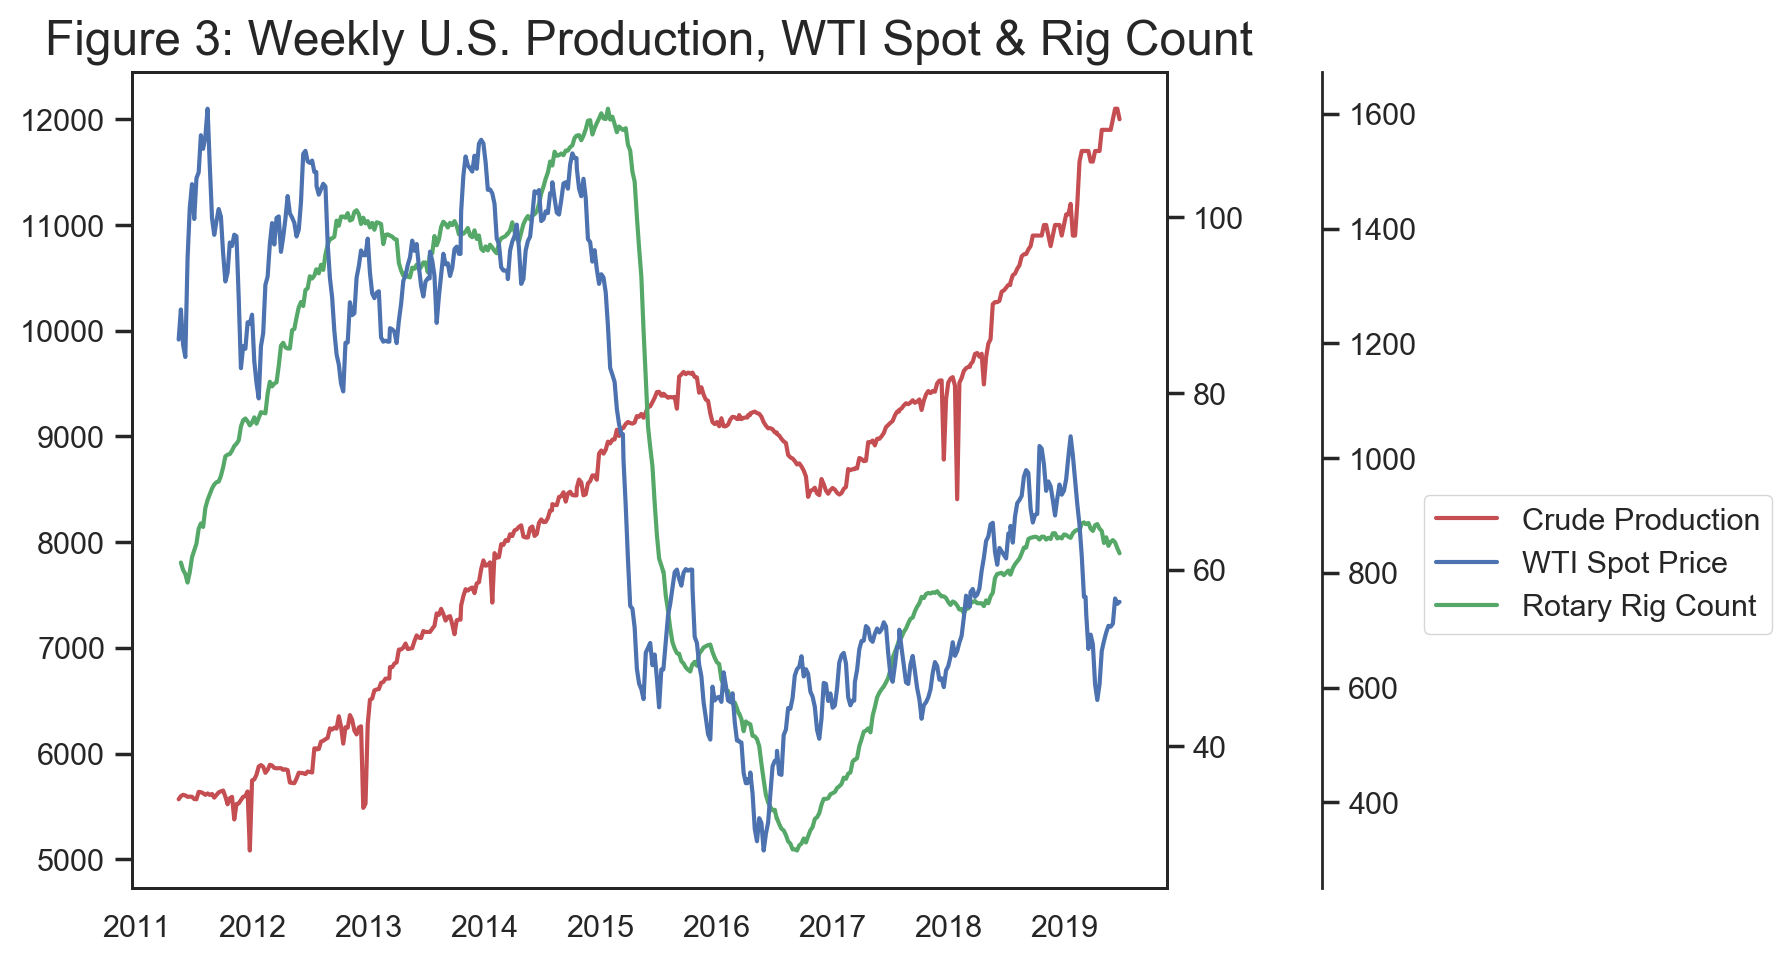

In [200]:
plt.style.use('ggplot')
sns.set_style("white")
fig, ax = plt.subplots(num=None, figsize=(9, 6), dpi=100)
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.15))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

plt.title("Figure 3: Weekly U.S. Production, WTI Spot & Rig Count", x=0.5, y=1, ha='center', fontsize='xx-large')
df['WTI'].plot(ax=ax, secondary_y=True, color="b", lw="1.5")
df['US_production_crude'].plot(ax=ax, color="r", lw="1.5")
# same ax as above since it's automatically added on the right
df['RigCount'].plot(ax=ax3, color="g", lw="1.5")
ax.tick_params(axis='x', rotation=0)
ax3.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax3.get_lines()[0]],\
           ['Crude Production','WTI Spot Price','Rotary Rig Count'], bbox_to_anchor=(1.6, 0.5))

plt.show()

Figure 3 illustrate the dynamic relationship between oil prices, the rotary rig count and the crude oil production level. Changes in oil prices leads changes in the rig count by up to one quarter. There are several reasons that explain the presence and relevance of lags in rig drilling. During periods of lower oil prices, oil companies initially revisit their resources that they reckon un-economic. There are also rig contracts and rigs rented for a number of years, which stand in the way of suddenly terminating drilling activity. The lags are also present during higher oil periods as it takes more time to acquire new leases/concessions, carry out seismic surveys, recruit workers, etc.

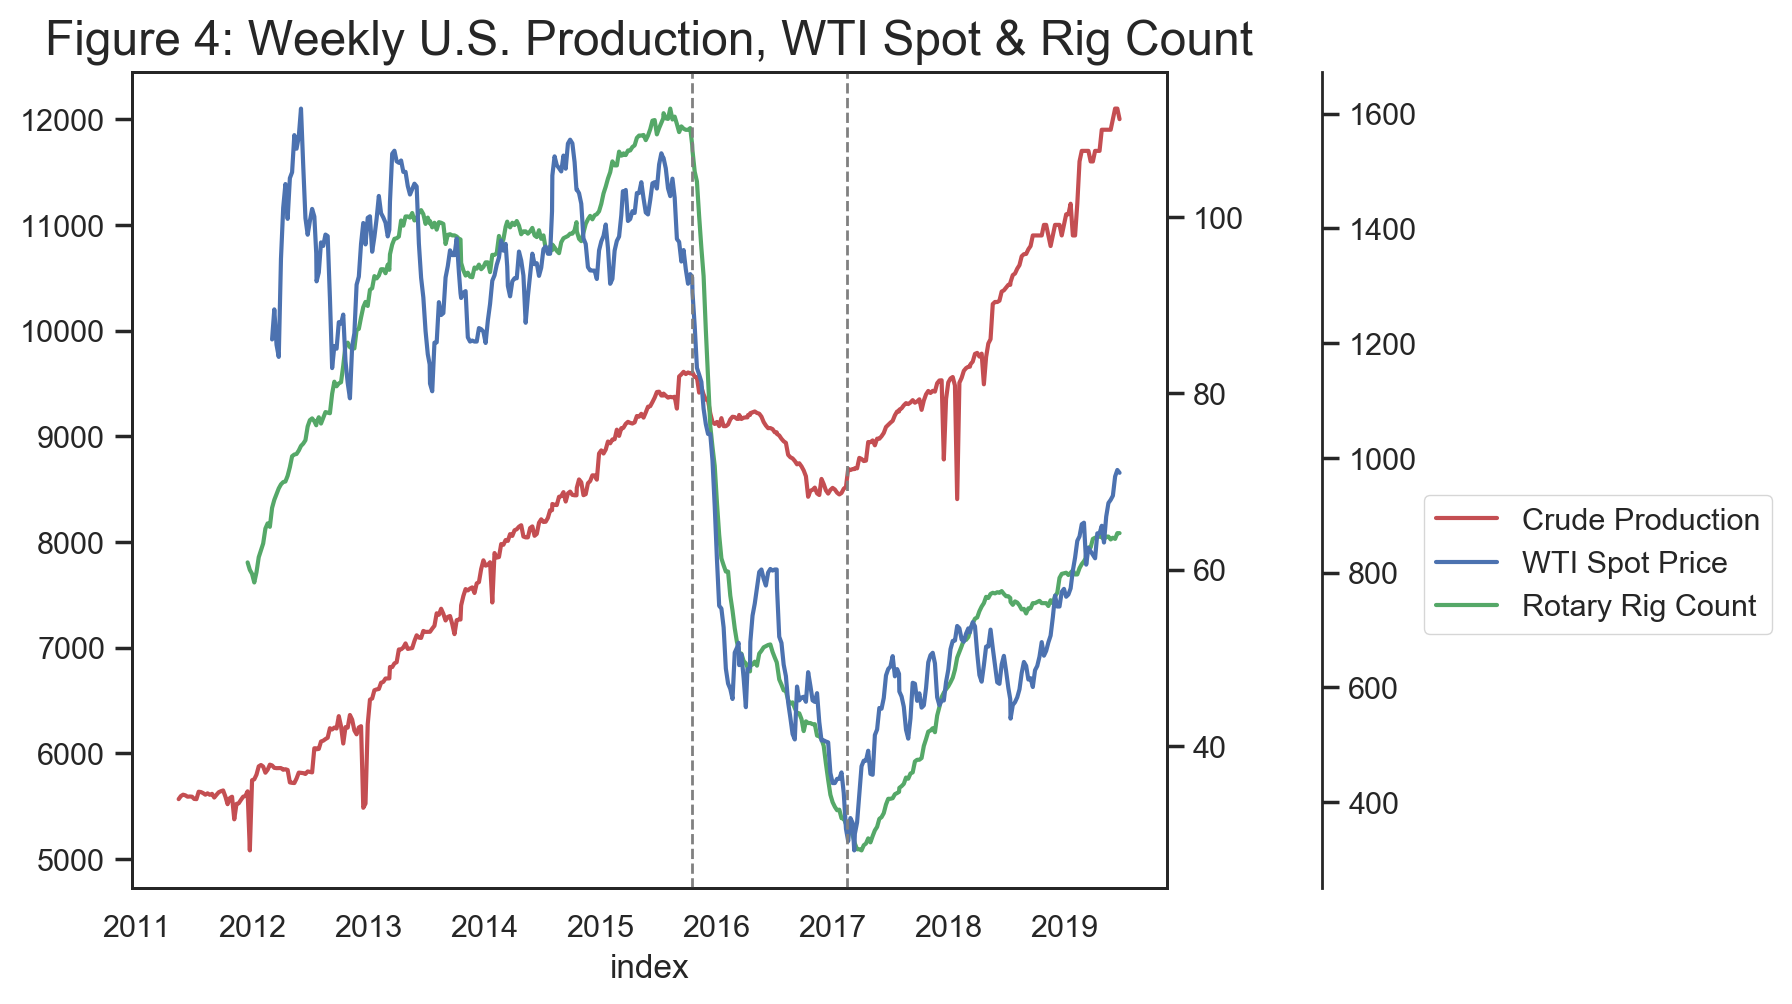

In [219]:
df["ShiftWTI"] = df['WTI'].shift(42)
df["ShiftRigCount"] = df['RigCount'].shift(30)

plt.style.use('ggplot')
sns.set_style("white")
fig, ax = plt.subplots(num=None, figsize=(9, 6), dpi=100)
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.15))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

plt.title("Figure 4: Weekly U.S. Production, WTI Spot & Rig Count", x=0.5, y=1, ha='center', fontsize='xx-large')
df["ShiftWTI"] .plot(ax=ax, secondary_y=True, color="b", lw="1.5")
df['US_production_crude'].plot(ax=ax, color="r", lw="1.5")
# same ax as above since it's automatically added on the right
df["ShiftRigCount"].plot(ax=ax3, color="g", lw="1.5")
ax.tick_params(axis='x', rotation=0)
ax3.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax3.get_lines()[0]],\
           ['Crude Production','WTI Spot Price','Rotary Rig Count'], bbox_to_anchor=(1.6, 0.5))

xposition = ["2015-07-01"]
for xc in xposition:
     plt.axvline(x=xc, color='gray', linestyle='--', lw=1) 
        
xposition = ["2016-11-01"]
for xc in xposition:
     plt.axvline(x=xc, color='gray', linestyle='--', lw=1) 

fig.savefig('prod.pdf', format='pdf', dpi=90, bbox_inches = 'tight')

plt.show()

Figure 4 is identical to figure 3, except that the rig count and the WTI spot price is now shifted. The figure highlights the importance of lags 

### Discussion

An alternative to using the rig count to predict production is to use well completion data to predict production. This choice would eliminate the endogenity problem that arise from changes in rig productivity over time. Yet well data is not readily accessible and doesn't lead production with a couple of months. By tracking the rig count, investors can observe fundamental changes that will have an effect in production months later. That is, investors can use reliable data to develop production forecasts months into the future.

### Credits

Ahmed Khalifa, Massimiliano Caporin, Nicholas Apergis, Bradley T. Ewing

### Appendix

In [202]:
df.reset_index(inplace=True)
df['Year'] = df['index'].dt.year
df.set_index('index', inplace=True)

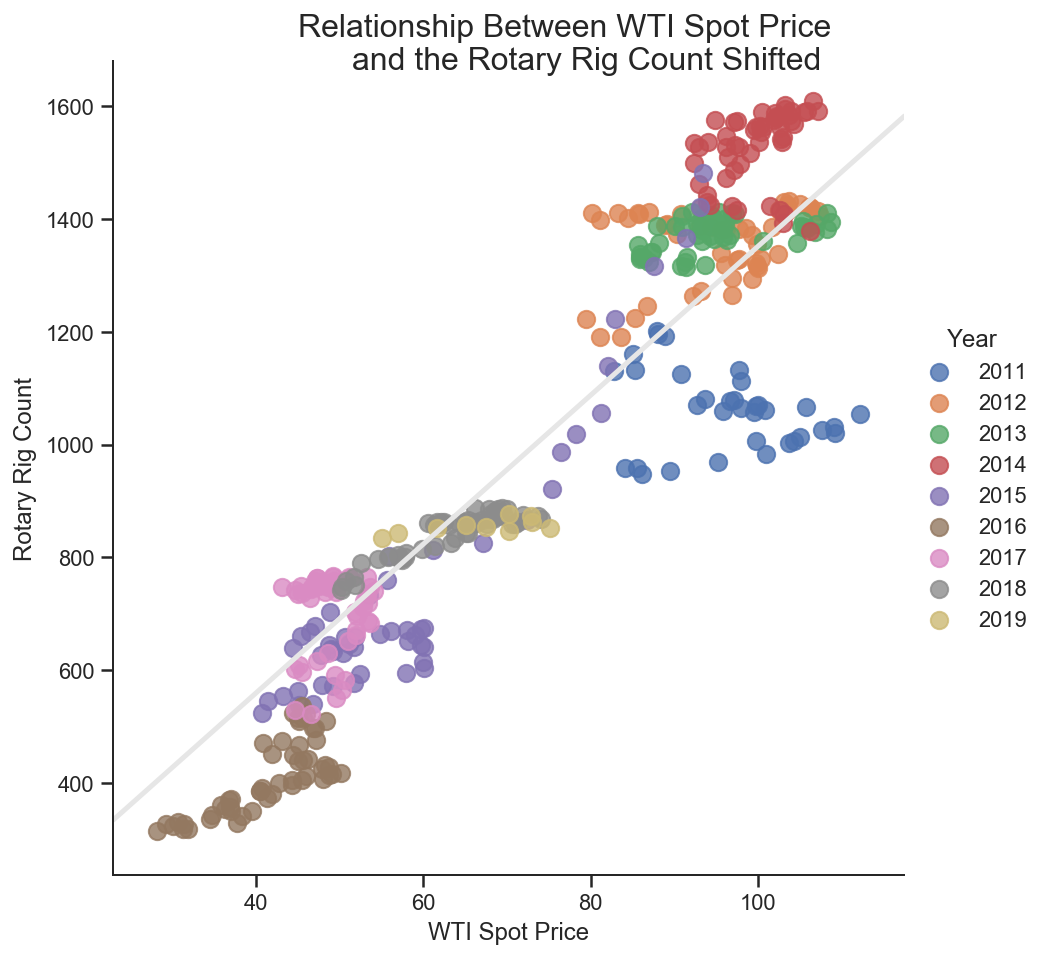

PearsonR Correlation Coefficient: 0.931 (WTI spot & Rig Count)


In [203]:
df["Shiftwti"] = dfSpot['WTI'].shift(15)

sns.set_style("white")
sns.set_style("ticks")

plot1 = sns.lmplot(x='Shiftwti', y='RigCount', data=df, hue='Year', fit_reg=False,  
        
    height = 6.5, aspect = 1, palette="deep",
    order=2, ci=None,  scatter_kws={"s": 75});

plot1 = sns.regplot('WTI', 'RigCount', data=df, color=".9", scatter=False, order=1, ci=None, line_kws={"lw":2.5});

plt.gca()

csfont = {'fontname':'Times New Roman'}
#plt.figtext(0.185, 0.155, "Data Source: Baker Hughes North America Rig Count", fontsize= 8)
plt.figtext(0.30, 0.99, "Relationship Between WTI Spot Price", fontsize= 16)
plt.figtext(0.35, 0.955, "and the Rotary Rig Count Shifted", fontsize= 16)
plt.ylabel("Rotary Rig Count", fontsize = 12)
plt.xlabel('WTI Spot Price', fontsize = 12)
plt.savefig('troll.pdf', format='pdf', dpi=100, bbox_inches = 'tight')

plt.show()

corr = df['Shiftwti'].corr(df['RigCount'])
print('PearsonR Correlation Coefficient:',round(corr, 3),'(WTI spot & Rig Count)') 

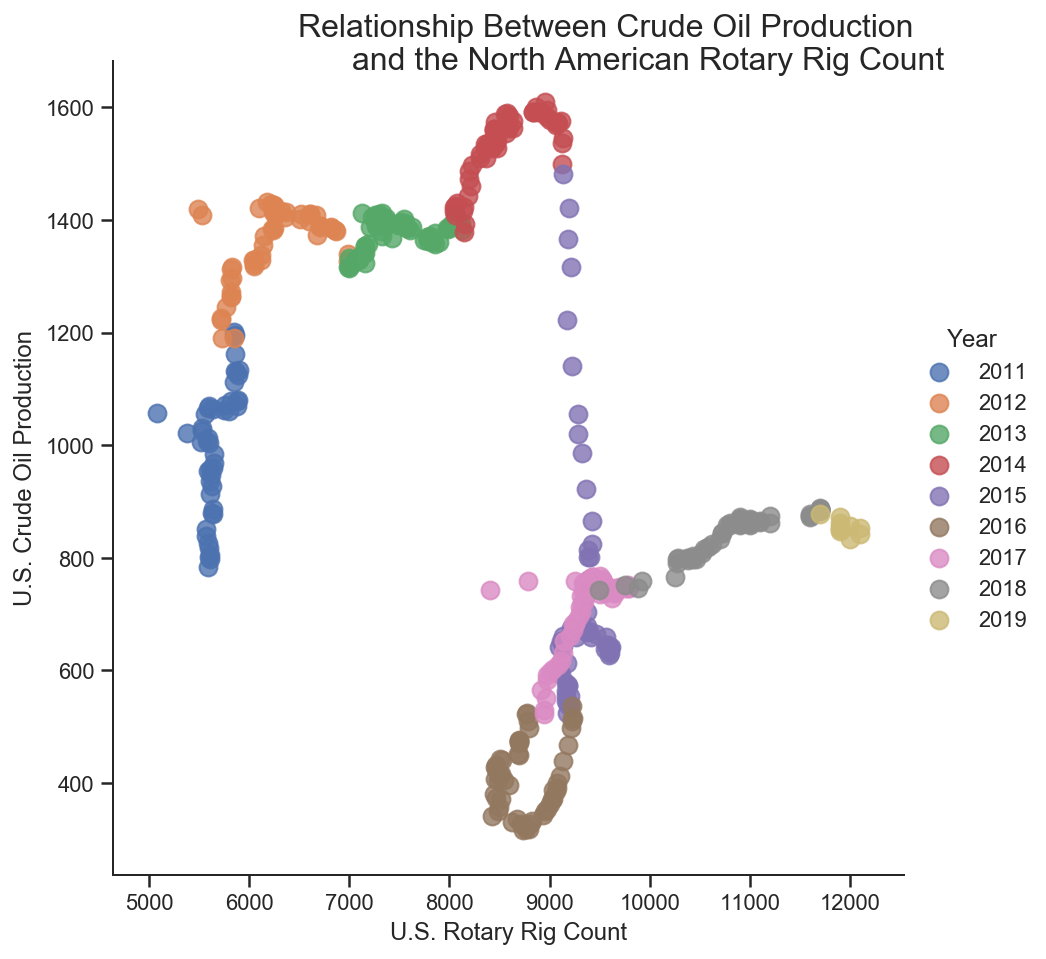

In [218]:
sns.set_style("white")
sns.set_style("ticks")

plot1 = sns.lmplot(x='US_production_crude', y='RigCount', data=df, hue='Year', fit_reg=False,  
        
    height = 6.5, aspect = 1, palette="deep",
    order=2, ci=None,  scatter_kws={"s": 80});

#plot1 = sns.regplot('Total_Oil', 'US_production_crude', data=df, color=".9", scatter=False, order=3, ci=None, line_kws={"lw":2.5});

plt.gca()


csfont = {'fontname':'Times New Roman'}
#plt.figtext(0.185, 0.155, "Data Source: Baker Hughes North America Rig Count", fontsize= 8)
plt.figtext(0.30, 0.99, "Relationship Between Crude Oil Production", fontsize= 16)
plt.figtext(0.35, 0.955, "and the North American Rotary Rig Count", fontsize= 16)
plt.ylabel("U.S. Crude Oil Production", fontsize = 12)
plt.xlabel('U.S. Rotary Rig Count', fontsize = 12)
plt.show()

The figure above shows the relationship between the U.S. rotary rig count and the U.S. crude oil production level. The scatterplot suggest that there is no clear linear relationship between the number of drilling rigs and production. With that said, there appears to be a linear relationship between 2010-2015 and 2017-today.

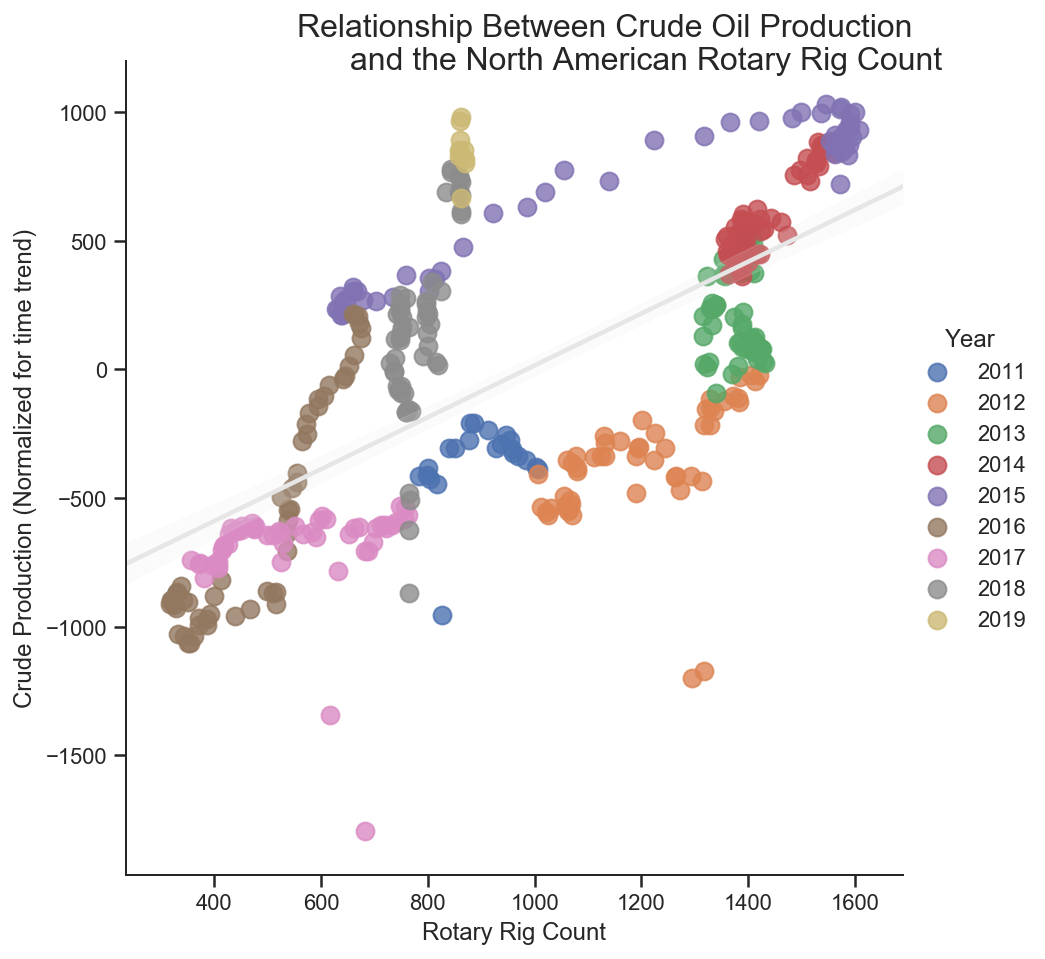

PearsonR Correlation Coefficient: 0.681 (Rigs & Production)


In [205]:
df['Trend'] = range(1, len(df) + 1)

m1 = smapi.OLS.from_formula('US_production_crude ~ Trend', df).fit()
df['ProductionNormalized'] = m1.resid

sns.set_style("white")
sns.set_style("ticks")
plot1 = sns.lmplot(x='RigCountShift', y='ProductionNormalized', data=df, hue='Year', fit_reg=False,  
        
    height = 6.5, aspect = 1, palette="deep",
    order=2, ci=None,  scatter_kws={"s": 80});

plot1 = sns.regplot('RigCountShift', 'ProductionNormalized', data=df, color=".9", scatter=False, order=1);

csfont = {'fontname':'Times New Roman'}
plt.figtext(0.30, 0.99, "Relationship Between Crude Oil Production", fontsize= 16)
plt.figtext(0.35, 0.955, "and the North American Rotary Rig Count", fontsize= 16)
plt.ylabel("Crude Production (Normalized for time trend)", fontsize = 12)
plt.xlabel('Rotary Rig Count', fontsize = 12)
plt.show()

corr = df['ProductionNormalized'].corr(df['RigCountShift'])
print('PearsonR Correlation Coefficient:',round(corr, 3),'(Rigs & Production)') 

The scatter plot demonstrates the realtionship between the number of drilling rigs and the crude oil production level while controlling for a deterministic time trend. The time trend is extracted from the U.S. crude oil production level by regressing the production level on a time variable. The idea is that the time trend will capture rig productivity which is changing over time. Note that when normalizing for a time trend, the vertical axis loses its economical interpretation.

In [206]:
dfPermian = pd.read_excel(r"https://www.eia.gov/petroleum/drilling/xls/dpr-data.xlsx", "Permian Region", skiprows=1, index_col="Month", parse_dates=["Month"])
dfBakken = pd.read_excel(r"https://www.eia.gov/petroleum/drilling/xls/dpr-data.xlsx", "Bakken Region", skiprows=1, index_col="Month", parse_dates=["Month"])
dfEagleFord = pd.read_excel(r"https://www.eia.gov/petroleum/drilling/xls/dpr-data.xlsx", "Eagle Ford Region", skiprows=1, index_col="Month", parse_dates=["Month"])

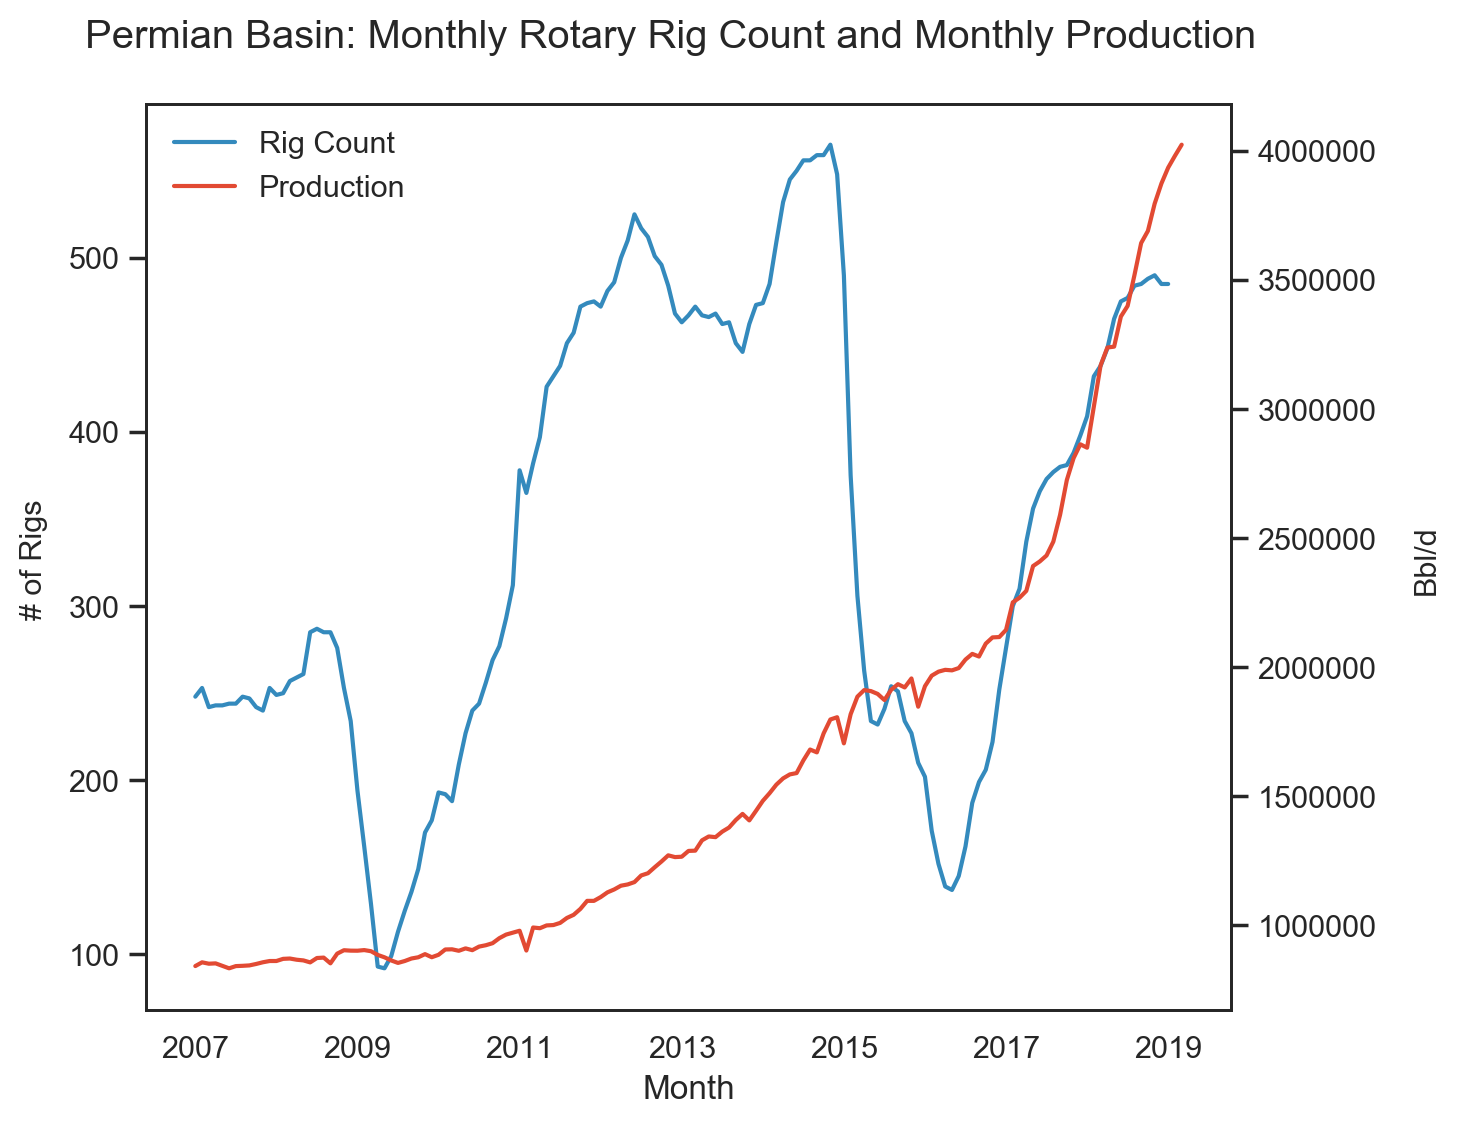

In [207]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = dfPermian['Total production'].plot(secondary_y=True, label='Production')
ax1 = dfPermian['Rig count'].plot(label='Rig Count')
ax2 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.suptitle('Permian Basin: Monthly Rotary Rig Count and Monthly Production', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.035, 0.5, '# of Rigs', va='center', rotation='vertical', fontsize=11)
plt.figtext(1.03, 0.5, 'Bbl/d', va='center', rotation='vertical', fontsize=11)
#ax1.tick_params(axis='x', rotation=0)
plt.show()

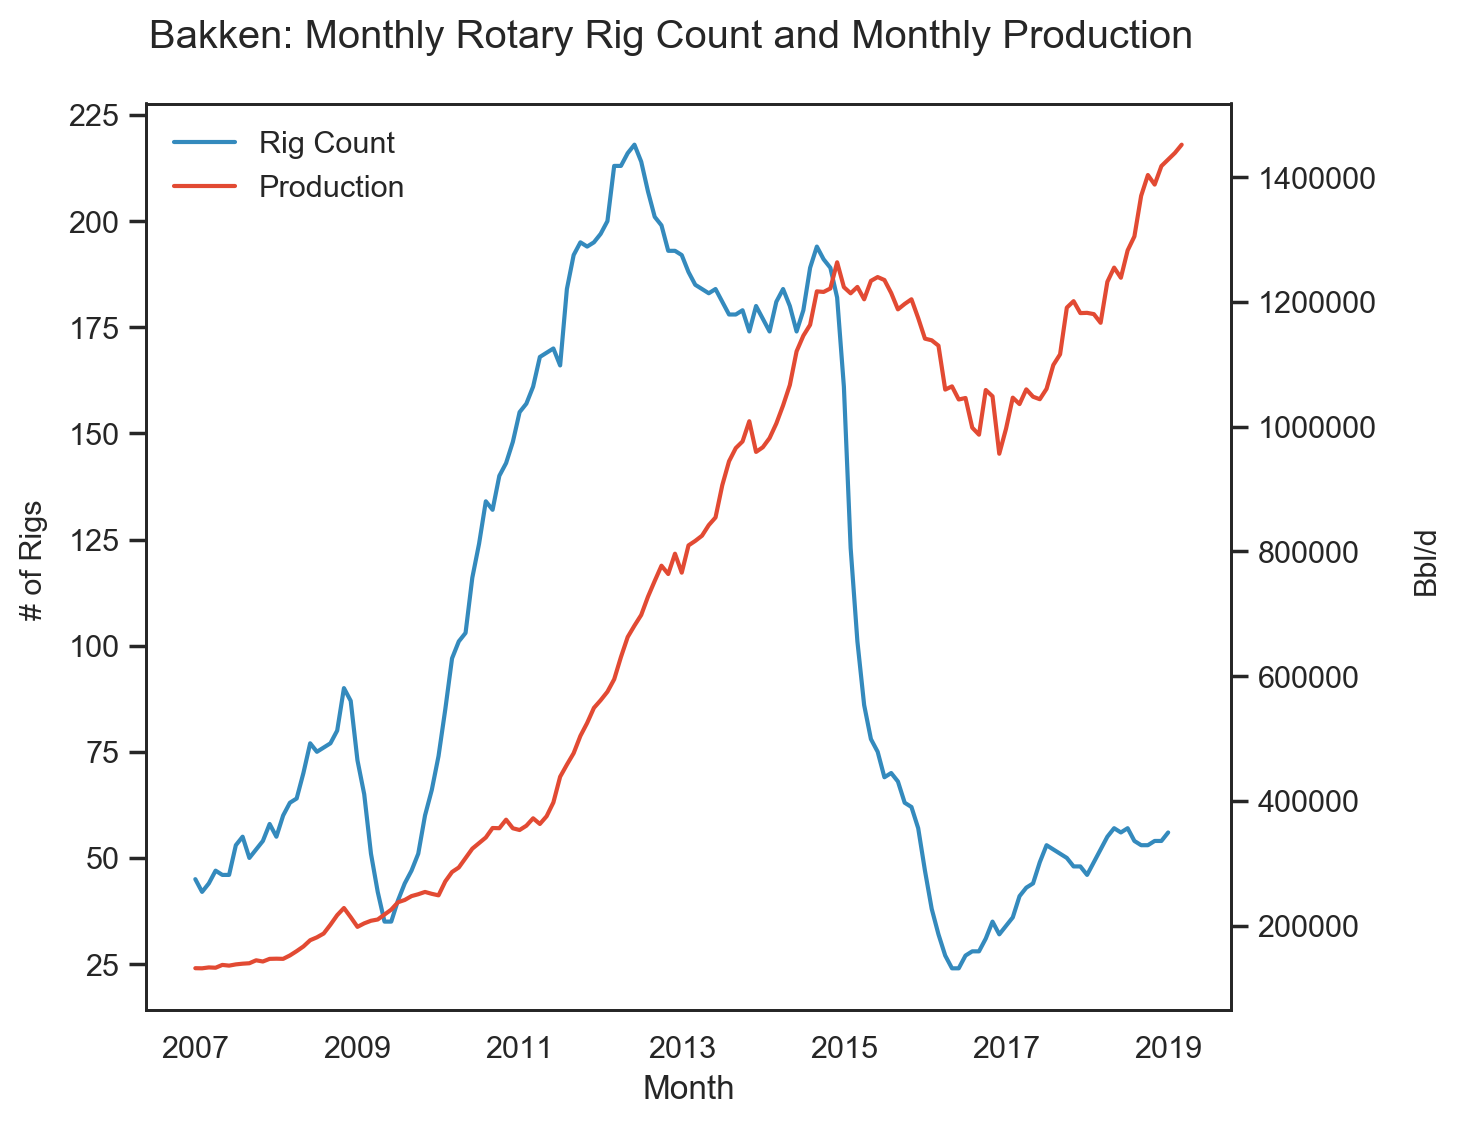

In [208]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = dfBakken['Total production'].plot(secondary_y=True, label='Production')
ax1 = dfBakken['Rig count'].plot(label='Rig Count')
ax2 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.suptitle('Bakken: Monthly Rotary Rig Count and Monthly Production', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.035, 0.5, '# of Rigs', va='center', rotation='vertical', fontsize=11)
plt.figtext(1.03, 0.5, 'Bbl/d', va='center', rotation='vertical', fontsize=11)
#ax1.tick_params(axis='x', rotation=0)
plt.show()

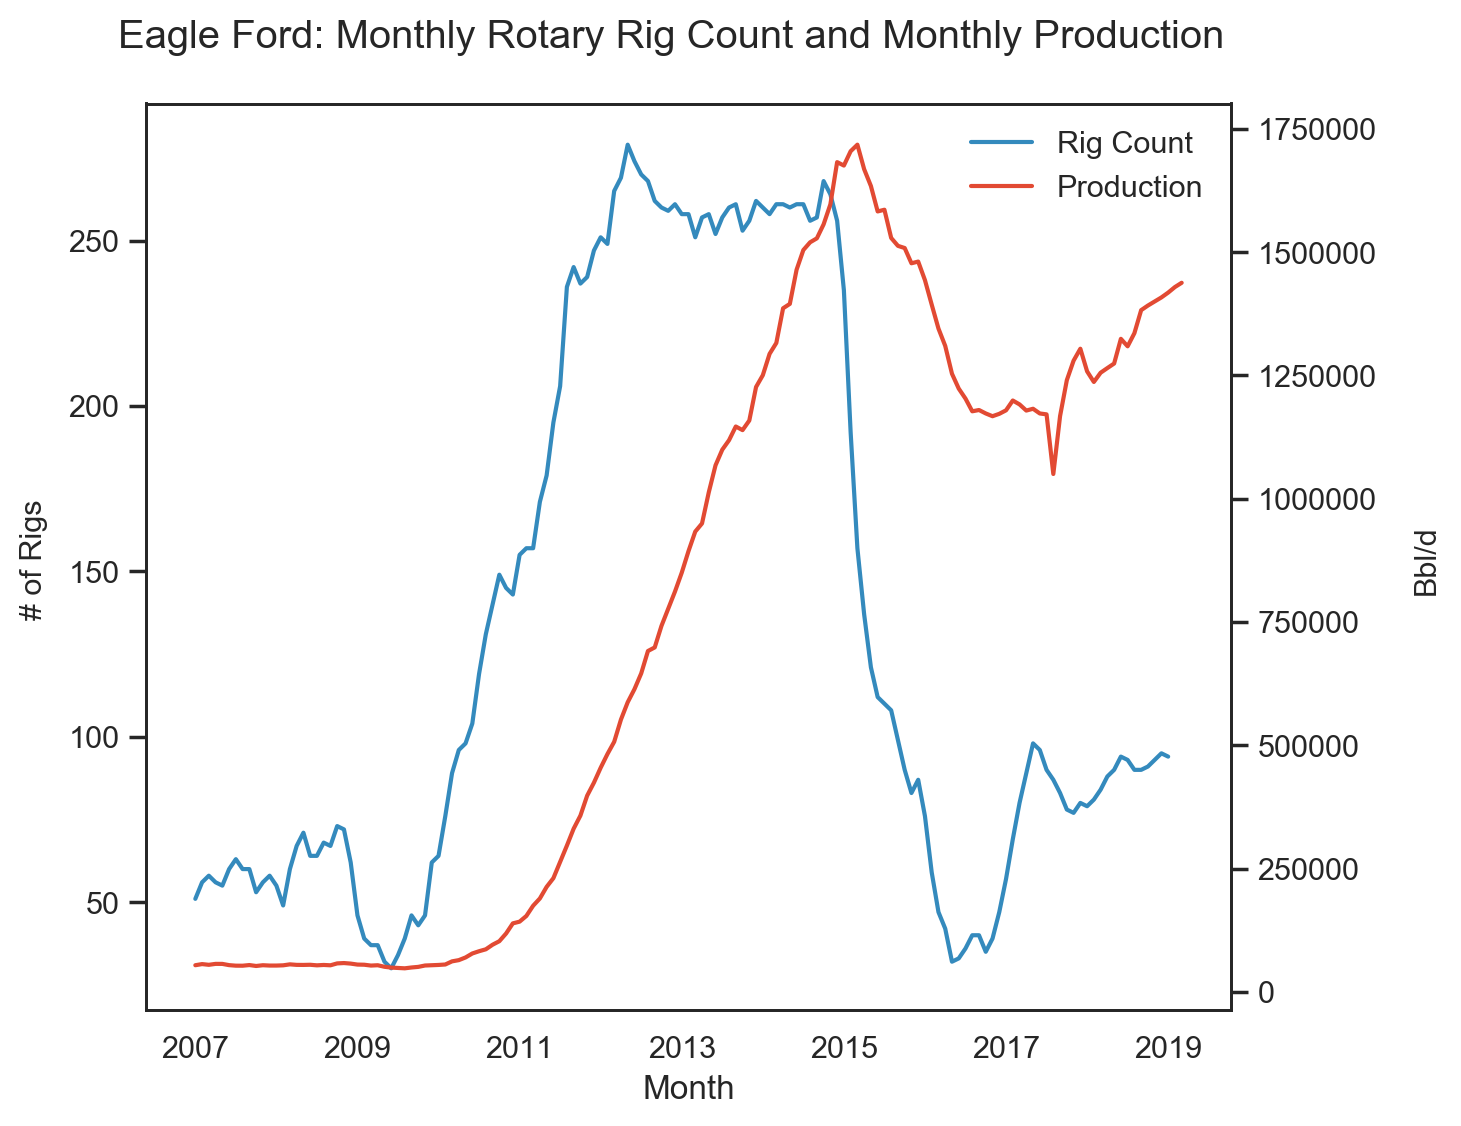

In [209]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = dfEagleFord['Total production'].plot(secondary_y=True, label='Production')
ax1 = dfEagleFord['Rig count'].plot(label='Rig Count')
ax2 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.suptitle('Eagle Ford: Monthly Rotary Rig Count and Monthly Production', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.035, 0.5, '# of Rigs', va='center', rotation='vertical', fontsize=11)
plt.figtext(1.03, 0.5, 'Bbl/d', va='center', rotation='vertical', fontsize=11)
#ax1.tick_params(axis='x', rotation=0)
plt.show()

In [210]:
dfDir = pd.read_csv(r"C:\Users\mla\Dev\cfehome\US Count by Trajectory.csv", skiprows=10, index_col="Date", parse_dates=["Date"])

In [211]:
dfDir= dfDir.dropna(axis=1, how='all')
dfDir.dropna(inplace=True)

dfDir["date"] = dfDir.index.map(lambda x: datetime(*xlrd.xldate_as_tuple(x, 0)))

dfDir.reset_index(inplace=True)
dfDir.set_index('date', inplace=True)

dfDir1 = dfDir["2011-01-01":"2050-01-01"]

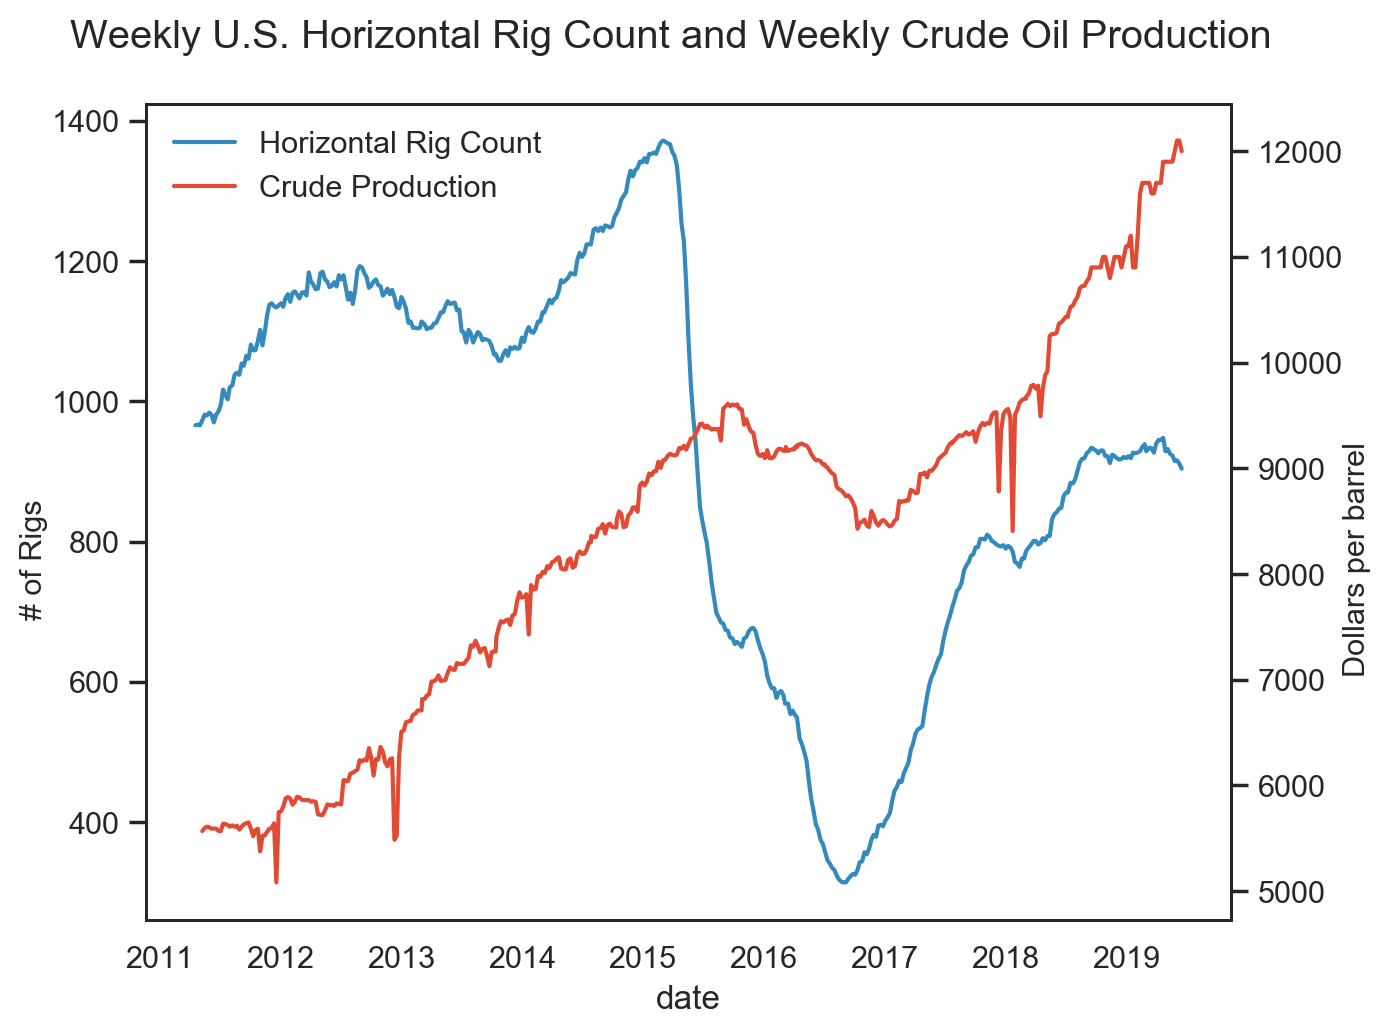

In [212]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df['US_production_crude'].plot(secondary_y=True, label='Crude Production')
ax1 = dfDir1['HORZ.'].plot(label='Horizontal Rig Count')
#ax1 = dfDir['DIR.'].plot(label='Directional')
ax2 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.suptitle('Weekly U.S. Horizontal Rig Count and Weekly Crude Oil Production', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.035, 0.5, '# of Rigs', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Dollars per barrel', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

In [213]:
dfOffshore = pd.read_csv(r"C:\Users\mla\Dev\cfehome\US L & OS Split by State.csv", skiprows=12, index_col="DATE", parse_dates=["DATE"])

In [214]:
dfOffshore= dfOffshore.dropna(axis=1, how='all')
dfOffshore.dropna(inplace=True)

dfOffshore["date"] = dfOffshore.index.map(lambda x: datetime(*xlrd.xldate_as_tuple(x, 0)))
dfOffshore.reset_index(inplace=True)
dfOffshore.set_index('date', inplace=True)

dfOffshore1 = dfOffshore["2011-01-01":"2050-01-01"]

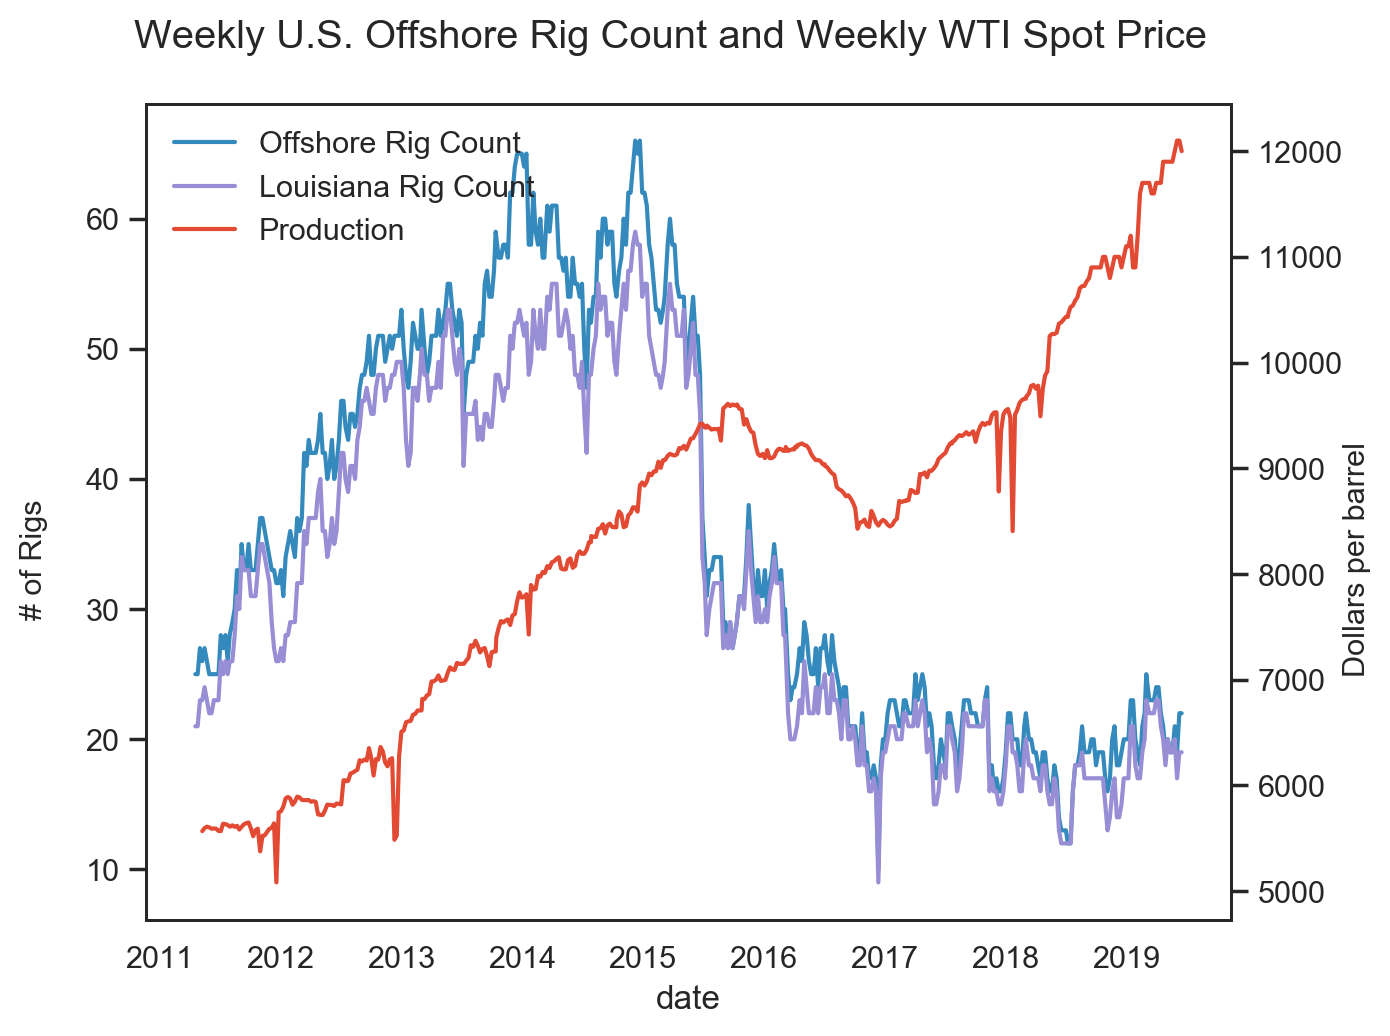

In [215]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df['US_production_crude'].plot(secondary_y=True, label='Production')
ax1 = dfOffshore1['Offshore.7'].plot(label='Offshore Rig Count')
ax1 = dfOffshore1['Offshore.4'].plot(label='Louisiana Rig Count')
ax2 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.suptitle('Weekly U.S. Offshore Rig Count and Weekly WTI Spot Price', x=0.5, y=0.95, ha='center', fontsize='x-large')
plt.figtext(0.035, 0.5, '# of Rigs', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Dollars per barrel', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()